<div>
<img src=https://www.institutedata.com/wp-content/uploads/2019/10/iod_h_tp_primary_c.svg width="300">
</div>

# Lab 5.1 
# *Logistic Regression*

## Predicting Survival on the Titanic

The Titanic sank during her maiden voyage after colliding with an iceberg (April 15, 1912). Due to a commercial decision there were insufficient lifeboats, a fact that was partially responsible for the loss 1,502 out of 2,224 passengers and crew. 

The Titanic dataset incorporates many features of typical real-world problems: a mixture of continuous and discrete features, missing data, linear covariance, and an element of random chance. Predicting survival therefore involves many practical data science skills.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

sns.set_style('whitegrid')
sns.set_context('poster')
%matplotlib inline

### 1. Load Data

Load the `titanic.csv` file into a DataFrame named "titanic", with index column = `PassengerId`. Display the head of the DataFrame.

In [2]:
# ANSWER
df = pd.read_csv('titanic.csv', index_col='PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Why would we want to set an index column based on `PassengerId`?

ANSWER: This column is the key to training and testing our model. We use it to partition the dataset and to test the predictions of our model against known outcomes.

<a name="datadictionary"></a>
### 2. Data Dictionary 

If a data dictionary is available, it is handy to include it in the notebook for reference:

| Variable |                                 Definition | Key                                            |
|----------|-------------------------------------------:|------------------------------------------------|
| Survival | Survival                                   | 0 = No, 1 = Yes                                |
| Pclass   | Ticket class                               | 1 = 1st, 2 = 2nd, 3 = 3rd                      |
| Sex      | Sex                                        |                                                |
| Age      | Age in years                               |                                                |
| SibSp    | # of siblings / spouses aboard the Titanic |                                                |
| Parch    | # of parents / children aboard the Titanic |                                                |
| Ticket   | Ticket number                              |                                                |
| Fare     | Passenger fare                             |                                                |
| Cabin    | Cabin number                               |                                                |
| Embarked | Port of Embarkation                        | C = Cherbourg, Q = Queenstown, S = Southampton |

### 2. EDA

Explore dataset. Find features to predict `Survived`. Get rid of null values. 

In [3]:
df.columns = df.columns.str.lower()
df.dtypes

survived      int64
pclass        int64
name         object
sex          object
age         float64
sibsp         int64
parch         int64
ticket       object
fare        float64
cabin        object
embarked     object
dtype: object

In [4]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
survived,891,NaN,NaN,NaN,0.383838,0.486592,0,0,0,1,1
pclass,891,NaN,NaN,NaN,2.30864,0.836071,1,2,3,3,3
name,891,891,"Cunningham, Mr. Alfred Fleming",1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,891,2,male,577,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,714,NaN,NaN,NaN,29.6991,14.5265,0.42,20.125,28,38,80
sibsp,891,NaN,NaN,NaN,0.523008,1.10274,0,0,0,1,8
parch,891,NaN,NaN,NaN,0.381594,0.806057,0,0,0,0,6
ticket,891,681,347082,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
fare,891,NaN,NaN,NaN,32.2042,49.6934,0,7.9104,14.4542,31,512.329
cabin,204,147,B96 B98,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
dup = df[df.duplicated('name')]
dup

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,


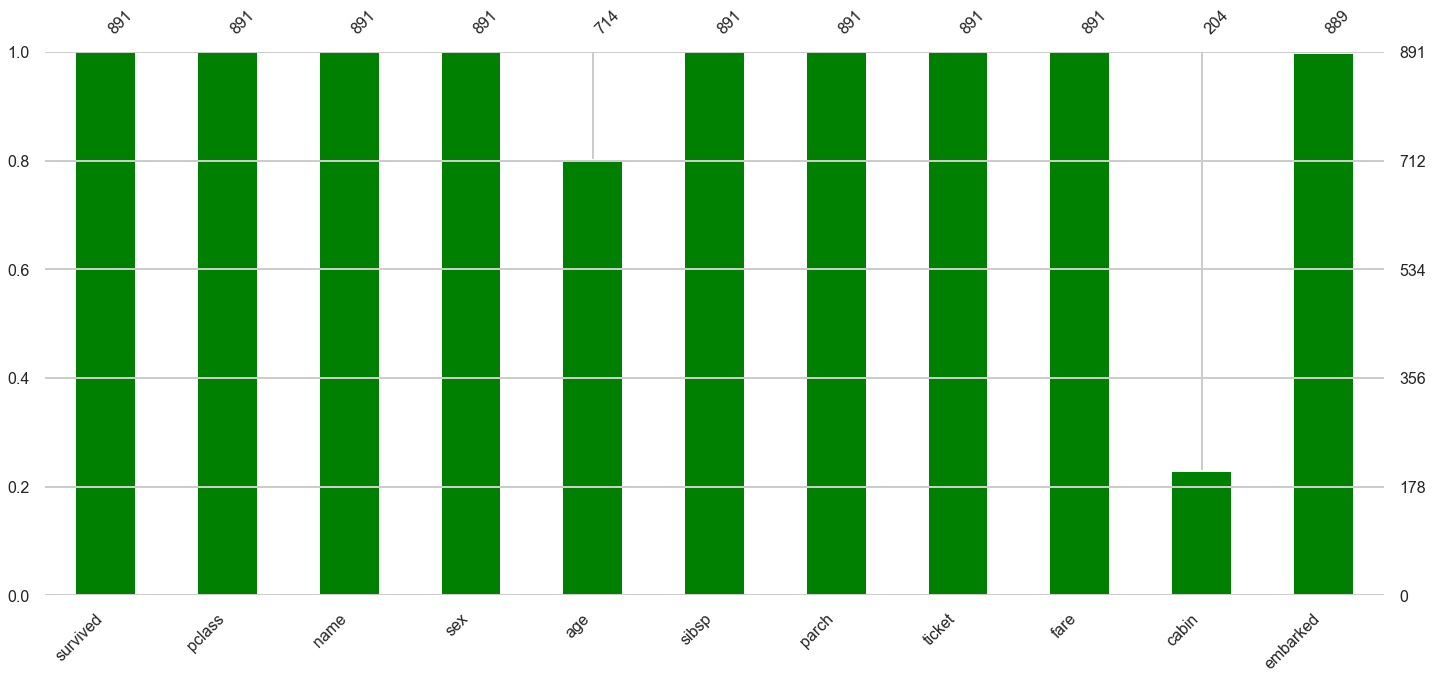

In [6]:
import missingno as msno
msno.bar(df, color='g')

In [7]:
(df.isnull().sum()).sum() / np.product(df.shape) * 100

8.835833078257322

In [8]:
df.isnull().sum()

survived      0
pclass        0
name          0
sex           0
age         177
sibsp         0
parch         0
ticket        0
fare          0
cabin       687
embarked      2
dtype: int64

In [9]:
df.shape

(891, 11)

In [10]:
# Fillna base on median age of pclass and sex category. 
df['age'] = df.groupby(['sex', 'pclass']).age.apply(lambda x: x.fillna(x.median()))

In [11]:
df.groupby(['sex', 'pclass']).age.median()

sex     pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: age, dtype: float64

In [12]:
# Compute the median values of age from sex and pclass. Form an value for all observation
#compute missing value for any columns that has missing
df.groupby(['sex', 'pclass']).age.transform('median')

PassengerId
1      25.0
2      35.0
3      21.5
4      35.0
5      25.0
       ... 
887    30.0
888    35.0
889    21.5
890    40.0
891    25.0
Name: age, Length: 891, dtype: float64

In [13]:
#see above code
#df['age'] = df['age'].fillna(df.groupby(['sex', 'pclass']).age.transform('median'))

In [14]:
df.head()

,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [15]:
df.cabin.fillna('NaN', inplace=True)

In [16]:
df.embarked.fillna('S', inplace=True)
df.isnull().sum()

survived    0
pclass      0
name        0
sex         0
age         0
sibsp       0
parch       0
ticket      0
fare        0
cabin       0
embarked    0
dtype: int64

Text(0.5, 1.0, 'Percentage of Survival from Ticket Class')

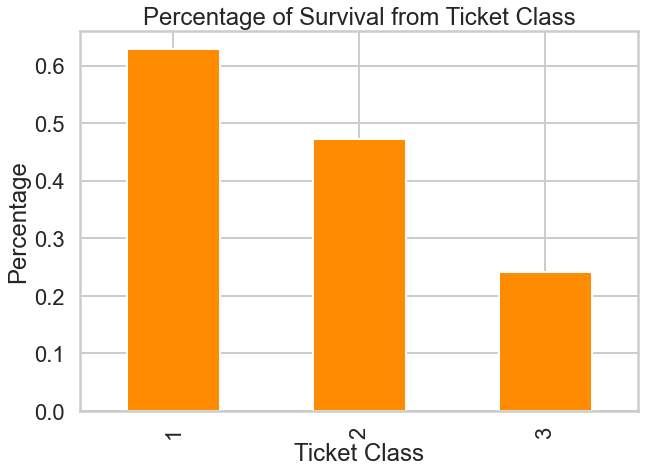

In [17]:
plt.figure(figsize=(10,7))
df.groupby('pclass')['survived'].mean().plot(kind='bar', color='darkorange')
plt.xlabel('Ticket Class')
plt.xticks(rotation=90)
plt.ylabel('Percentage')
plt.title('Percentage of Survival from Ticket Class')

In [18]:
df.groupby('pclass')['survived'].value_counts()

pclass  survived
1       1           136
        0            80
2       0            97
        1            87
3       0           372
        1           119
Name: survived, dtype: int64

In [19]:
df.groupby('pclass')['survived'].mean()

pclass
1    0.629630
2    0.472826
3    0.242363
Name: survived, dtype: float64

In [20]:
df.groupby('pclass')['survived'].value_counts(normalize=True).sort_index()

pclass  survived
1       0           0.370370
        1           0.629630
2       0           0.527174
        1           0.472826
3       0           0.757637
        1           0.242363
Name: survived, dtype: float64

Ticket Class 1 has a higher chance of survival from the Titanic incident. Over 60% of passengers survive the crash compare to ticket class 3 which is 25%. 

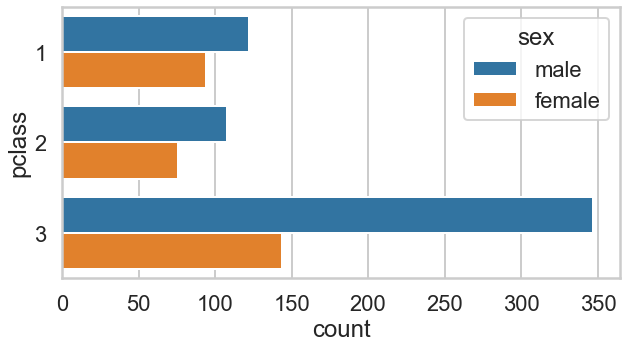

In [21]:
plt.figure(figsize=(10,5))
sns.countplot(data=df, y='pclass', hue='sex')

### 3. Numerical Predictors Only

#### 3.1. Set Target and Features

To begin, let's try a model based on the passenger class (`Pclass`) and parents/children features (`Parch`):

In [22]:
X = df[['pclass', 'parch']]
y = df['survived']

#### 3.2 Partition

Partition the data into training and testing subsets:

- Use `random_state` = 1

In [23]:
# ANSWER
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

#### 3.3. Build Model

Prepare a model by creating an instance of the `LogisticRegression` class from the `sklearn.linear_model` library:

In [24]:
# ANSWER
model = LogisticRegression()


Now train it on the training data subset, using the `fit` method of the model object (Nb. by default, `fit` will print the hyperparameters of the model):

In [25]:
# ANSWER
model.fit(X_train, y_train)

LogisticRegression()

The computed coefficients are an array (`coef_`) stored in the 1st element of an array:

In [26]:
# ANSWER
model.coef_

array([[-0.90824213,  0.33432156]])

__Logit Function (1 Logit = 2.717):__ log(p / 1 - p) #Take natural logarithm (ln)<br>

__Logit to Probability of Pclass:__ prob = odds / (1 + odds)<br>
(0.908 * 2.717) = 2.467 <br> 
2.467 / 3.467 = 0.711 ~ 71%<br> 

__Logit to Probability of Parch:__<br>
(0.334 * 2.717) / (1 + (0.334 * 2.717)) = 0.475 ~ 48% 

__Coefficient explaination:__<br>

__Pclass: -0.908__ meaning for every unit increase in pclass the log(odds of survived) declined by 0.908. In other words, as your pclass increase the odds of survived is against you. Precisely, for every unit increase in pclass your chance of survival decline by 71%  <br> 

__Parch: 0.334__ meaning for every unit increase in parch the log(odds of survived) increase by 0.334. In other words, as your parch increase the odds of survived is higher (in favour of survival). Precisely, for every unit increase in parch your chance of survival increase by 48%


The computed intercept (`intercept_`) is the 1st element of another array:

In [27]:
# ANSWER
model.intercept_

array([1.40820621])

__Intercept explaination:__
__Intercept: 1.4__ When Pclass & Parch at 0, the log(odds of survived) is 1.408. In other words, if you have no Ticket class & no parent/children aboard Titanic the odds of survived is 1.4 on the log scale.

We can create tuples of the predictor names and coefficients like this:

In [28]:
# ANSWER
feature_cols = X_train.columns
print(set(zip(feature_cols, model.coef_[0])))

{('pclass', -0.9082421341469836), ('parch', 0.33432155514777906)}


If we want formatted output, here is a neat way to list the coefficients by predictor:

In [29]:
for col in zip(X_train.columns, model.coef_[0]):
    print(f'{col[0]}:  {col[1]:+.6f}')

pclass:  -0.908242
parch:  +0.334322


This result implies that survival declines with passenger class (i.e. 1st class is highest) but increases with the number of parents or children in a group.

Let's see how well the model fit the training data. The `accuracy_score` is the proportion of correct predictions:

In [30]:
# ANSWER
from sklearn.metrics import accuracy_score

y_train_pred = model.predict(X_train)

score = accuracy_score(y_train, y_train_pred)
print(f'Train score: {score}')

Train score: 0.6924157303370787


What is the  `accuracy_score` for the test data?

In [31]:
# ANSWER
y_pred = model.predict(X_test)

score = accuracy_score(y_test, y_pred)
print(f'Test score: {score}')

Test score: 0.6536312849162011


In [32]:
model.score(X_test, y_test)

0.6536312849162011

What can we say aout this result?

ANSWER
- 65% is not a good prediction rate regard to life and dead matter. 
- The model did not perform well on the test data. Hence, this could reflect the model's performance on future data. 

#### 3.4. Add `AGE` as Feature

Let's include `Age` in the model. As we know from our EDA, this feature has many missing values. We don't want to throw away so many rows, so we will replace `NA` values with imputed values (e.g. the overall mean age):

In [90]:
# ANSWER
X_1 = df[['pclass', 'parch', 'age']]
y_1 = df['survived']

In [91]:
# Build Model
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_1, y_1, test_size = 0.2, random_state=1)

model_1 = LogisticRegression()

# Fit Model
model_1.fit(X_train1, y_train1)

y_pred_1 = model_1.predict(X_test1)

# Score
score_1 = accuracy_score(y_test1, y_pred_1)
print(f'2nd Model Test Score: {score_1}')

2nd Model Test Score: 0.664804469273743


So, including age did little to reduce the variance in our model. Why might this be?

ANSWER

- Age add more noise to the model
- Age is not an important predictor for the model 
- Age does not have a linear relationship with survival

Let's see where the model is going wrong by showing the Confusion Matrix:

In [92]:
# ANSWER

from sklearn.metrics import confusion_matrix

logreg = LogisticRegression()
logreg.fit(X_train1, y_train1)
y_pred_class = logreg.predict(X_test1)
print(confusion_matrix(y_test1, y_pred_class))

[[87 19]
 [41 32]]


Nb. Here is how `confusion_matrix` arranges its output:

In [93]:
print(np.asarray([['TN', 'FP'], ['FN', 'TP']]))

[['TN' 'FP']
 ['FN' 'TP']]


In [94]:
from sklearn.metrics import classification_report

report = classification_report(y_test1, y_pred_class, target_names=['pclass', 'age'], output_dict=True)
classie = pd.DataFrame(report)
classie.T

,precision,recall,f1-score,support
pclass,0.679688,0.820755,0.743590,106.000000
age,0.627451,0.438356,0.516129,73.000000
accuracy,0.664804,0.664804,0.664804,0.664804
macro avg,0.653569,0.629555,0.629859,179.000000
weighted avg,0.658384,0.664804,0.650826,179.000000


Which type of error is more prevalent?

ANSWER: ...

Maybe we aren't using the right cut-off value. By default, we are predicting that `Survival` = True if the probability >= 0.5, but we could use a different threshold. The ROC curve helps us decide (as well as showing us how good our predictive model really is):

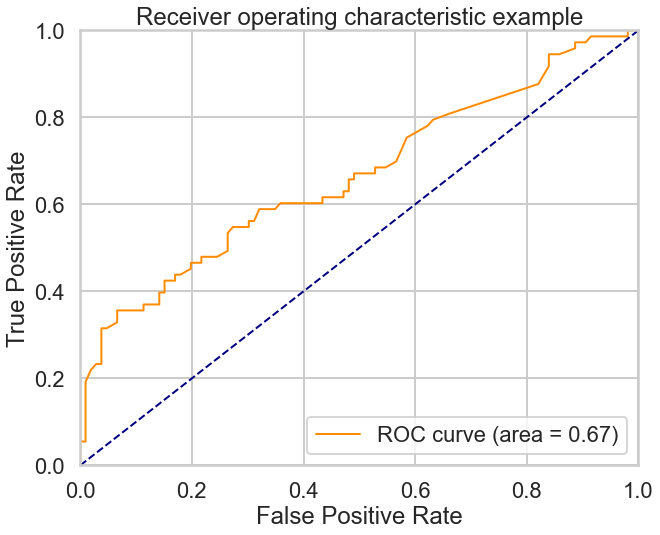

In [96]:
from sklearn.metrics import roc_curve, auc
# Generate the prediction values for each of the test observations using predict_proba() function rather than just predict
preds = logreg.predict_proba(X_test1)[:,1]

# Store the false positive rate(fpr), true positive rate (tpr) in vectors for use in the graph
fpr, tpr, _ = roc_curve(y_test1, preds)

# Store the Area Under the Curve (AUC) so we can annotate our graph with theis metric
roc_auc = auc(fpr, tpr)

# Plot the ROC Curve
plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

### 4. Including Categorical Predictors

So far, we've only used numerical features for prediction. Let's convert the character features to dummy variables so we can include them in the model:

In [118]:
df_dummies = pd.get_dummies(data = df, columns = ['sex', 'embarked', 'pclass'], 
                                      prefix = ['sex', 'embarked', 'pclass'] )
df_dummies.head()

,survived,name,age,sibsp,parch,ticket,fare,cabin,sex_female,sex_male,embarked_C,embarked_Q,embarked_S,pclass_1,pclass_2,pclass_3
PassengerId,,,,,,,,,,,,,,,,
1,0,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,0,1,0,0,1,0,0,1
2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,1,0,1,0,0,1,0,0
3,1,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,1,0,0,0,1,0,0,1
4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,1,0,0,0,1,1,0,0
5,0,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,0,1,0,0,1,0,0,1


So, this created a column for every possible value of every categorical variable. (A more compact approach would have been to reduce the number of dummy variables by one for each feature, so that the first vriable from each captures two possible states.)

Now that we have data on sex, embarkation port, and passenger class we can try to improve our `Age` imputation by stratifying it by the means of groups within the passenger population:

In [119]:
#df_dummies['age'] = df_dummies[["age", "parch", "sex_male", "pclass_1", "pclass_2"]].groupby(["parch", "sex_male", "pclass_1", "pclass_2"])["age"].transform(lambda x: x.fillna(x.mean()))

In [121]:
print(df_dummies.dtypes, df.shape)

survived        int64
name           object
age           float64
sibsp           int64
parch           int64
ticket         object
fare          float64
cabin          object
sex_female      uint8
sex_male        uint8
embarked_C      uint8
embarked_Q      uint8
embarked_S      uint8
pclass_1        uint8
pclass_2        uint8
pclass_3        uint8
dtype: object (891, 11)


Now train the model using the expanded set of predictors and compute the accuracy score for the test set:

In [125]:
# ANSWER
# Set Feature Both Numerical, Categorical
X_2 = df_dummies[['pclass_1', 'pclass_2', 'pclass_3', 'sex_female', 'sex_male', 'embarked_C', 'embarked_Q', 'embarked_S',
                 'parch', 'age']]
y_2 = df_dummies['survived']

X_train, X_test, y_train, y_test = train_test_split(X_2, y_2, test_size=0.2, random_state=1) 

Plot the ROC curve for the new model:

D:\Ricky\envs\Python 38 and R\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


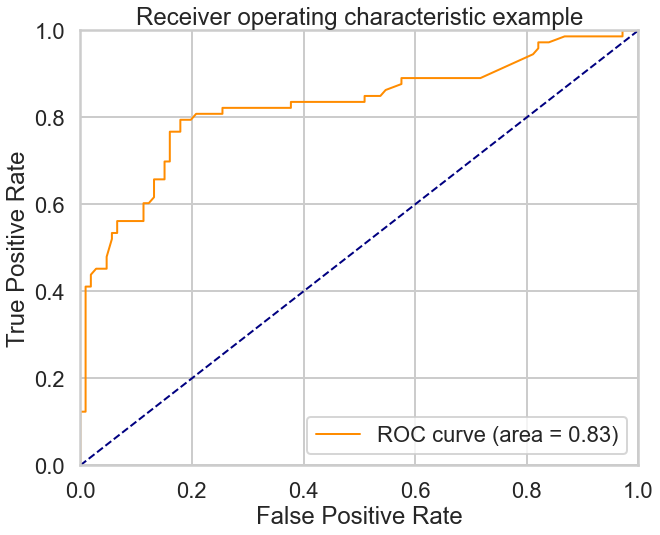

In [132]:
# ANSWER

logreg = LogisticRegression()

logreg.fit(X_train, y_train)

preds = logreg.predict_proba(X_test)[:,1]

fpr, tpr, _ = roc_curve(y_test, preds)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10,8))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw = lw, label = 'ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color = 'navy', lw = lw, linestyle = '--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc = "lower right")
plt.show()

Can we improve the model by including the remaining features?

In [0]:
# ANSWER
I believed we can categorise age to Kid, Teen, Middle-Age, Elders

## Homework

1. Remove the `random_state` parameter (if you have used), so that the data partition will be different every time, and run through the final modelling process a few times. Do the results change?

2. Use cross-validation to assess the quality of the model when overfitting is controlled. Does the accuracy improve?

3. Look at the `fpr` & `tpr` vectors for the best model.

In [134]:
from sklearn.model_selection import cross_val_score

result = cross_val_score(logreg, X_2, y_2, cv=10)

D:\Ricky\envs\Python 38 and R\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
D:\Ricky\envs\Python 38 and R\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



---



---



> > > > > > > > > © 2019 Institute of Data


---



---



